# Task 1 – Predicting UFO Sightings

This notebook develops a predictive model to estimate the number of UFO sightings per state per year using historical and temporal features.  
The data comes from the [NUFORC UFO Sightings dataset](https://www.kaggle.com/datasets/NUFORC/ufo-sightings).

### Steps:
- Data cleaning and preprocessing
- Feature engineering (e.g., shape proportions, rolling averages, time indicators)
- Model training (Random Forest)
- Performance evaluation and interpretation of feature importance

### Summary and Evaluation:
- RMSE: 31.17
- MAE: 9.86
- R²: 0.695
- The model performed well, with no major signs of overfitting (Train R² ≈ 0.742)

### Feature Importance:
Key features included:
- Shape frequency from 3 years prior (e.g., `cross_prev3`, `chevron_prev3`)
- Average log duration (`avg_log_duration_prev3`)
- Temporal indicators like `night_prev3`, `weekday_prev3`

### Recommendations:
- Use cross-validation or time-aware train/test split
- Try additional models like XGBoost
- Add external data (e.g., state population)
- Remove redundant or noisy features

**Import**

In [2]:
!pip install pycountry
import pandas as pd
import numpy as np
import re
import pycountry
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 34.1 MB/s eta 0:00:00


**connect to drive and read the file**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/UFCDATA.csv', encoding='latin1')

<ipython-input-4-510d2be315e6>:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/UFCDATA.csv', encoding='latin1')


**See the data**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88875 entries, 0 to 88874
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              88875 non-null  object 
 1   city                  88679 non-null  object 
 2   state                 81356 non-null  object 
 3   country               76314 non-null  object 
 4   shape                 85757 non-null  object 
 5   duration (seconds)    88873 non-null  object 
 6   duration (hours/min)  85772 non-null  object 
 7   comments              88749 non-null  object 
 8   date posted           88875 non-null  object 
 9   latitude              88875 non-null  object 
 10  longitude             88875 non-null  float64
 11  Unnamed: 11           195 non-null    float64
dtypes: float64(2), object(10)
memory usage: 8.1+ MB


In [6]:
df

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,Unnamed: 11
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111,NaN
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082,NaN
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667,NaN
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833,NaN
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
88870,09/09/2013 22:00,napa,ca,us,other,1200.0,hour,Napa UFO&#44,9/30/2013,38.2972222,-122.284444,NaN
88871,09/09/2013 22:20,vienna,va,us,circle,5.0,5 seconds,Saw a five gold lit cicular craft moving fastl...,9/30/2013,38.9011111,-77.265556,NaN
88872,09/09/2013 23:00,edmond,ok,us,cigar,1020.0,17 minutes,2 witnesses 2 miles apart&#44 Red &amp; White...,9/30/2013,35.6527778,-97.477778,NaN
88873,09/09/2013 23:00,starr,sc,us,diamond,0.0,2 nights,On September ninth my wife and i noticed stran...,9/30/2013,34.3769444,-82.695833,NaN


**Clean up and organize the data**

**clean and fix datetime -**


The original datetime column contained numerous invalid or inconsistent entries, including missing values, numeric Excel-style date codes and strings with malformed formats ("24:00" as a time value).
To address this, I first converted valid date strings using pd.to_datetime.
Then, for rows where the date was a numeric value representing days since December 30, 1899 (as in Excel), I applied a separate conversion.
I fixed entries with "24:00" by replacing it with "00:00" and incrementing the date by one day.

In [7]:
df['datetime_fixed'] = pd.to_datetime(df['datetime'], errors='coerce')

mask_failed = df['datetime_fixed'].isna()

mask_excel_numbers = df.loc[mask_failed, 'datetime'].astype(str).str.match(r'^\d+(\.\d+)?$')

df.loc[mask_failed[mask_failed].index[mask_excel_numbers], 'datetime_fixed'] = pd.to_datetime(
    df.loc[mask_failed[mask_failed].index[mask_excel_numbers], 'datetime'].astype(float),
    errors='coerce',
    origin='1899-12-30',
    unit='D'
)

mask_24 = df['datetime'].astype(str).str.contains('24:00', na=False)

fixed_24 = pd.to_datetime(
    df.loc[mask_24, 'datetime'].astype(str).str.replace('24:00', '00:00', regex=False),
    errors='coerce'
)

fixed_24 += pd.Timedelta(days=1)

df.loc[mask_24, 'datetime_fixed'] = fixed_24

df[df['datetime_fixed'].isna()]['datetime'].astype(str).value_counts()


,count
datetime,


**Parsing and Correction duration-**

The duration (seconds) column included missing values (NaN) as well as String values ​​containing numbers and a hyphen after a number (2', 8').
To clean the column, I used a regular expression to strip out all non-numeric characters except for decimal points.
The resulting strings were converted to numeric values using pd.to_numeric, and rows with remaining invalid durations were removed.



In [8]:
mask_not_numeric = pd.to_numeric(df['duration (seconds)'], errors='coerce').isna()

df.loc[mask_not_numeric, 'duration (seconds)'].astype(str).value_counts()

df['duration_clean'] = df['duration (seconds)'].astype(str) \
    .str.replace(r"[^0-9.]", "", regex=True) \
    .str.strip()

df['duration_clean'] = pd.to_numeric(df['duration_clean'], errors='coerce')

mask_not_numeric_after = df['duration_clean'].isna()

df = df[~mask_not_numeric_after]


**create onr colum that represent state or county (state/county)-**

Many records were missing values in the state, country, and city fields, making it difficult to geolocate the sighting.
To address this, I created a unified state/county field.
If a valid state was present, its value was used.
Otherwise, the country value was used as a fallback.

For rows missing both state and country, I attempted to infer the location from the city text using a custom function.

This function searched for substrings in parentheses ("city (France)") or other patterns and matched them against a comprehensive list of known country and state codes.
Only records with a resolved state/county value were retained for further analysis.

In [9]:
mask_state = df['state'].isna()
df['state/county'] = np.where(mask_state, df['country'], df['state'])

def extract_country_or_state_from_text(text):
    if pd.isna(text):
        return None

    text = str(text).lower()

    us_state_codes = {
        'al', 'ak', 'az', 'ar', 'ca', 'co', 'ct', 'de', 'fl', 'ga', 'hi', 'id', 'il', 'in', 'ia',
        'ks', 'ky', 'la', 'me', 'md', 'ma', 'mi', 'mn', 'ms', 'mo', 'mt', 'ne', 'nv', 'nh', 'nj',
        'nm', 'ny', 'nc', 'nd', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'vt',
        'va', 'wa', 'wv', 'wi', 'wy'
    }

    us_state_names = {
        'alabama', 'alaska', 'arizona', 'arkansas', 'california', 'colorado', 'connecticut',
        'delaware', 'florida', 'georgia', 'hawaii', 'idaho', 'illinois', 'indiana', 'iowa',
        'kansas', 'kentucky', 'louisiana', 'maine', 'maryland', 'massachusetts', 'michigan',
        'minnesota', 'mississippi', 'missouri', 'montana', 'nebraska', 'nevada', 'new hampshire',
        'new jersey', 'new mexico', 'new york', 'north carolina', 'north dakota', 'ohio',
        'oklahoma', 'oregon', 'pennsylvania', 'rhode island', 'south carolina', 'south dakota',
        'tennessee', 'texas', 'utah', 'vermont', 'virginia', 'washington', 'west virginia',
        'wisconsin', 'wyoming'
    }

    all_country_names = {country.name.lower() for country in pycountry.countries}
    all_country_alt_names = set()
    for country in pycountry.countries:
        all_country_alt_names.update(map(str.lower, [country.name, country.alpha_2, country.alpha_3]))
    all_country_names.update(all_country_alt_names)

    matches = re.findall(r'\((.*?)\)', text)
    for match in matches:
        parts = re.split(r'[,/]', match)
        for part in parts:
            cleaned = part.strip()
            if cleaned in all_country_names or cleaned in us_state_codes or cleaned in us_state_names:
                return cleaned

    for token in re.split(r'\W+', text):
        token = token.strip()
        if token in all_country_names or token in us_state_codes or token in us_state_names:
            return token

    return None

mask_missing_both = df['state'].isna() & df['country'].isna()
df.loc[mask_missing_both, 'state/county'] = df.loc[mask_missing_both, 'city'].apply(extract_country_or_state_from_text)


<ipython-input-9-d0d978af1bc9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['state/county'] = np.where(mask_state, df['country'], df['state'])


**proccess DF-**

To enhance the dataset with potentially predictive information, I extracted several new features from the cleaned datetime column.
These include:
1. year, month, dayinweek, and hour – standard time-based attributes.
2. Weekday/Weekend – derived from the day of the week to indicate whether the sighting occurred on a weekday or during the weekend.
3. day/night – based on the hour, labeling sightings as daytime (6:00–18:00) or nighttime (18:00–6:00).
4. season – categorized as Winter, Spring, Summer, or Fall depending on the month.

In [10]:
df['datetime'] = pd.to_datetime(df['datetime_fixed'])
df['year'] = df['datetime_fixed'].dt.year
df['dayinweek'] = df['datetime_fixed'].dt.dayofweek
df['month'] = df['datetime_fixed'].dt.month
df['hour'] = df['datetime_fixed'].dt.hour

def nightOrDay(hour):
  if 6<=hour<18:
    return 'day'
  else:
    return 'night'

def season(month):
  if month in [12, 1, 2]:
      return 'Winter'
  elif month in [3, 4, 5]:
      return 'Spring'
  elif month in [6, 7, 8]:
      return 'Summer'
  else:
      return 'Fall'

def weekdayorweekend(day):
  if day in [0,1,2,3,4]:
    return 'weekday'
  else:
    return 'weekend'

df['Weekday/Weekend'] = df['dayinweek'].apply(weekdayorweekend)
df['day\night'] = df['hour'].apply(nightOrDay)
df['season'] = df['month'].apply(season)


<ipython-input-10-d5b5b656307a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = pd.to_datetime(df['datetime_fixed'])
<ipython-input-10-d5b5b656307a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['datetime_fixed'].dt.year
<ipython-input-10-d5b5b656307a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

**Create data for target value - feature aggregation by Year and State:**

To prepare the data for modeling, I constructed an aggregated feature table where each row corresponds to a unique (year, state/county) pair.
This table summarizes the distribution of various categorical and temporal attributes across UFO sightings reported in that year and location.

1. Shape Distribution:
I grouped rare shapes (those with fewer than 100 occurrences) into an "Other" category, then calculated the relative frequency of each shape using a normalized crosstab.
The result is a set of percentage-based columns representing the proportion of sightings for each shape per year and state.
2. Average Duration:
For each (year, state/county) group, I calculated the average log(duration) to reduce skewness and minimize the effect of extreme outliers.
This feature captures the typical duration of sightings in a given year and location.
3. More feature:
Additional features include the proportion of sightings during weekdays vs. weekends, in each season (Winter, Spring, Summer, Fall), and during day vs. night.
These were also calculated using normalized crosstabs to reflect their distribution within each group.

All of these components were merged into new table (df_target) using a left join.

In [11]:
#Shape Distribution
shape_counts = df['shape'].value_counts()
rare_shapes = shape_counts[shape_counts < 100].index
df['shape_grouped'] = df['shape'].apply(lambda x: x if x not in rare_shapes else 'Other')

shape_crosstab = pd.crosstab(
    index=[df['year'], df['state/county']],
    columns=df['shape_grouped'],
    normalize='index'
).reset_index()
shape_crosstab = shape_crosstab.fillna(0)

#Average Duration
df_target = df.groupby(['year', 'state/county']).size().reset_index(name='num_events')
df['log_duration'] = np.log1p(df['duration_clean'])
df_log_duration = df.groupby(['year', 'state/county'])['log_duration'].mean().reset_index(name='avg_log_duration')

#Proportion of sightings during weekdays vs. weekends
WeekdayWeekend_crosstab = pd.crosstab(
    index=[df['year'], df['state/county']],
    columns=df['Weekday/Weekend'],
    normalize='index'
).reset_index()
WeekdayWeekend_crosstab = WeekdayWeekend_crosstab.fillna(0)

#Proportion of sightings during seasons
season_crosstab = pd.crosstab(
    index=[df['year'], df['state/county']],
    columns=df['season'],
    normalize='index'
).reset_index()
season_crosstab = season_crosstab.fillna(0)

#Proportion of sightings during day vs. night
nightorday_crosstab = pd.crosstab(
    index=[df['year'], df['state/county']],
    columns=df['day\night'],
    normalize='index'
).reset_index()
nightorday_crosstab = nightorday_crosstab.fillna(0)

#Left join for all the components
df_list= [df_log_duration,shape_crosstab,WeekdayWeekend_crosstab,season_crosstab,nightorday_crosstab]
for val in df_list:
  df_target = pd.merge(df_target, val, on=['year', 'state/county'], how='left')

<ipython-input-11-c638d6f3d605>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['shape_grouped'] = df['shape'].apply(lambda x: x if x not in rare_shapes else 'Other')
<ipython-input-11-c638d6f3d605>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_duration'] = np.log1p(df['duration_clean'])


**Filtering countries\states with insufficient historical data-**

To ensure model reliability and reduce noise, we filtered out state/county values with insufficient historical data.
Specifically, we computed the number of distinct years with observations per state and removed any state that appeared in fewer than 10 years.

To support this threshold choice, we also calculated the median and mean number of years per state.
Using the median helps mitigate the influence of outliers (e.g., states with extremely long or short reporting histories), ensuring that we neither over-filter nor under-filter the data.
This step helps focus the modeling on locations with enough historical variation to support meaningful prediction.


In [12]:
state_year_counts = df_target.groupby('state/county')['year'].nunique().reset_index(name='num_years')
low_year_states = state_year_counts[state_year_counts['num_years'] < 10]['state/county']
df_target = df_target[~df_target['state/county'].isin(low_year_states)]

# fmedian = state_year_counts['num_years'].median()
# fmedian
# fmean = state_year_counts['num_years'].mean()
# fmean

**Create predict DF-**

In order to perform valid forecasting, it is crucial to avoid using aggregated information from the same year we are trying to predict.
Using such data would result in information leakage, where the model learns from the very outcome it’s supposed to forecast.

To address this, I constructed a predictive dataset in which each row represents a specific (year, state/county) pair, but the features are based solely on data from previous years.
This was done using a rolling mean over a fixed window of 3 prior years (rolling(window=3, min_periods=3)), applied separately for each state.
By applying a shift(1) before the rolling operation, I ensured that only data strictly before the current year contributed to the features.

This guarantees that each row in the training set represents what would have been known at the time — making the modeling process both realistic and temporally valid.

In [13]:
df_sorted = df_target.sort_values(by=['state/county', 'year'])

rolling_features = []
n_years = 3

for col in df_target.columns:
    if col not in ['year', 'state/county', 'num_events']:
        rolled = df_sorted.groupby('state/county')[col].shift(1).rolling(window=n_years, min_periods=n_years).mean()
        df_sorted[f'{col}_prev{n_years}'] = rolled
        rolling_features.append(f'{col}_prev{n_years}')
df_final = df_sorted.dropna(subset=rolling_features + ['num_events'])

**Train/Test Split**

After constructing the predictive dataset with lagged features, I split the data into training and testing sets using a 75/25 ratio.
The split was performed randomly but with a fixed random_state to ensure reproducibility.

In [14]:
X = df_final[rolling_features]
y = df_final['num_events']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

**Model Selection – Random Forest Regressor**

To model the number of UFO sightings per year and state, I selected a regression model — as the target variable is continuous, not categorical.

I initially experimented with linear regression, but due to the lack of linear relationships between features and the target, the results were poor and often unrealistic.
This led me to explore more regression models and specifically the Random Forest Regressor, which proved better suited to the structure and limitations of the data.
I had previously studied decision trees in the context of classification during an Introduction to Data Engineering course, and that make me interest in learn and applying this model for regression task.

The decision to use Random Forest was motivated by several key advantages that match to handling the problems in the task data:
1. Nonlinear Modeling Capability:
Random Forests can model complex, nonlinear relationships.
2. Robustness to Outliers:
Since the model aggregates predictions from multiple decision trees (each trained on random feature subsets), it is less sensitive to extreme values in the data.
3. Reduced Overfitting:
Instead of relying on a single tree (which is prone to overfitting), Random Forest combines many shallow trees and averages their outputs.
4. Works Well on Small Datasets:
Given the relatively small size of the engineered dataset (after filtering by year and location), Random Forests are a strong option, as they don’t require large sample sizes for effective learning.

Initially, I trained the model with default hyperparameters. However, this resulted in overfitting — for example, the model achieved an R² of 0.97 on the training set, while performing poorly on the test set.
To mitigate this,  I restricted the model’s complexity by limiting both the number and size of the trees.
Specifically, I reduced the maximum tree depth, required a minimum number of samples in each leaf node, and limited the number of features considered at each split.
These constraints were introduced to ensure the model learns generalizable patterns from the data rather than memorizing the training set.

The final model configuration achieved a good balance between bias and variance, with solid predictive performance across unseen data.




In [15]:
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=10,
    max_features='sqrt',
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

**Model Evaluation and Interpretation of Results**

To evaluate the predictive performance of the model, I used three standard regression metrics:

**RMSE** (Root Mean Squared Error) – measures the square root of the average squared differences between predicted and actual values. It penalizes large errors more heavily and is expressed in the same units as the target variable. Lower values indicate better accuracy and fewer large mistakes.

**MAE** (Mean Absolute Error) – calculates the average absolute difference between predictions and true values. It is more robust to outliers than RMSE, and provides a simple interpretation: how far off predictions are, on average.

**R²** (Coefficient of Determination) – represents the proportion of variance in the target variable explained by the model. Values closer to 1 indicate stronger explanatory power, while values near 0 imply poor fit.

1. **Results on the Test Set**
  - Test RMSE: 31.17
  - Test MAE: 9.86
  - Test R²: 0.695

  These results suggest that the model has a moderate error margin.
  On average, it misses the correct value by about 11 sightings per year and state (MAE), but some predictions may deviate by significantly more — as reflected by the higher RMSE.
  The gap between RMSE and MAE highlights the presence of a few large prediction errors, likely due to outliers.
  However, an R² of 0.695 shows that the model captures approximately 70% of the variance, which is a strong result considering the noisy and irregular nature of the data.

2. **Overfitting Analysis via Train/Test Comparison**
  To assess overfitting, I also evaluated the model on the training data:
  - Train RMSE: 25.1
  - Train MAE: 8.933
  - Train R²: 0.777

  As expected, the training error is slightly lower, but the performance gap between train and test sets is not extreme.
  This indicates that the model generalizes well and is not overfitting — it learns meaningful patterns without simply memorizing the training set.

Overall, the model balances accuracy and generalization effectively. It delivers stable predictions across diverse regions and years, while remaining resilient to noise and irregularities in the data.

In [27]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest Set Performance:")
print(" - Test RMSE:", rmse)
print(" - Test MAE:", mae)
print(" - Test R²:", r2)

y_train_pred = model.predict(X_train)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

print("\nTraining Set Performance:")
print(" - Train RMSE:", rmse_train)
print(" - Train MAE:", mae_train)
print(" - Train R²:", r2_train)


Test Set Performance:
 - Test RMSE: 31.173081464608952
 - Test MAE: 9.856637118998858
 - Test R²: 0.6947922491832672

Training Set Performance:
 - Train RMSE: 25.107672028897113
 - Train MAE: 8.933039304201586
 - Train R²: 0.7866848543643826


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Actual vs. Predicted Sightings - scatter plot:**

The scatter plot compares actual versus predicted sightings for each year-state pair.
Most predictions cluster near the red reference line, indicating that the model performs reasonably well across typical ranges.
However, the model tends to underpredict extreme values, as seen in cases where the true number of sightings exceeds 300.

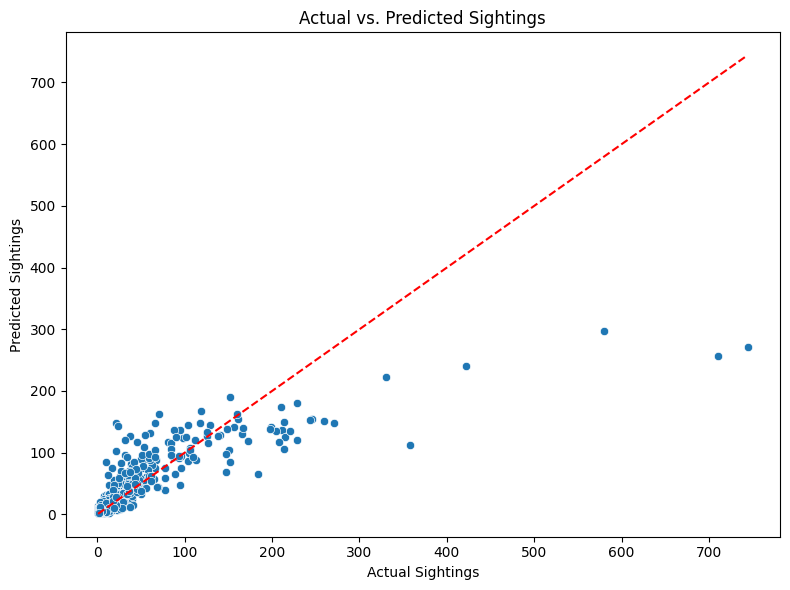

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('Actual Sightings')
plt.ylabel('Predicted Sightings')
plt.title('Actual vs. Predicted Sightings')
plt.tight_layout()
plt.show()


**Importance Feature barplot:**

The feature importance plot shows that the most influential variables in the model are the relative frequencies of specific UFO shapes over the previous three years.
Shapes such as "cross", "cone", and "chevron" had the highest predictive power, indicating that certain sighting patterns are historically correlated with future sighting volume.
This suggests that the type of reported shape plays a significant role in anticipating future UFO activity within a given region.

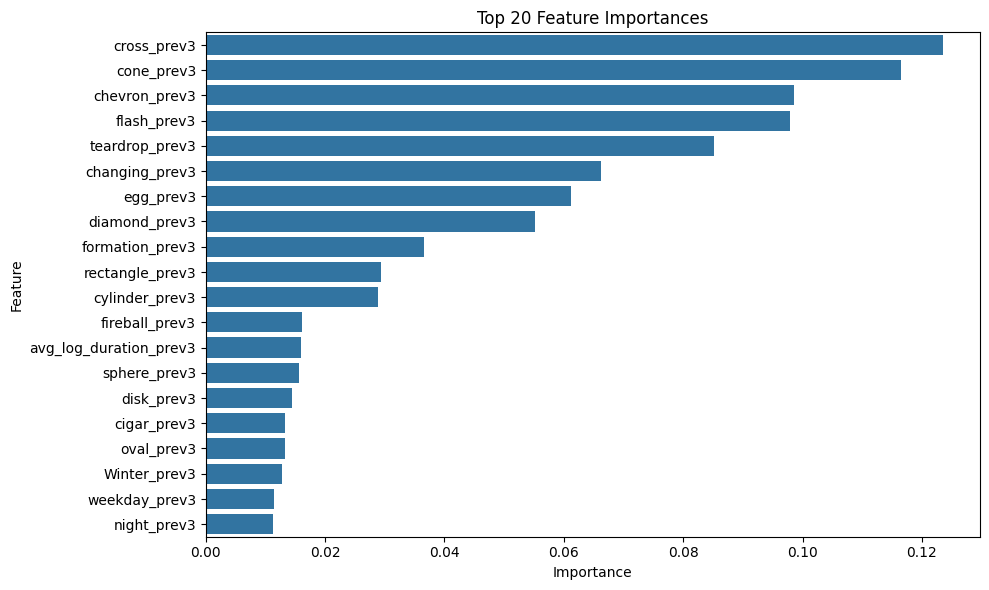

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
importances = model.feature_importances_
feature_names = X.columns

feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(20))
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()